# Drug toxicity screening on human iPSC-derived cardiomyocites

## Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are frequently used drugs in cancer treatment. Unfortunately, cardiomyopathy may occur as a severe side effect of these drugs due to cardiotoxicity.   
  
Here, you will compare the transcriptomes of iPSC-derived cardiomyocites treated with two different FDA-approved TKIs to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.
- Idarubicin
- Gefinitib

## Objectives
1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between mutant and WT for both drugs.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.

In [26]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import gseapy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [27]:
counts = pd.read_csv(
    "Session_3_4/split_datasets/counts_msn05_group_3.txt", sep="\t", index_col=0
)
counts

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,CTRL_12,GEF_1,GEF_2,GEF_3,GEF_4,IDA_1,IDA_2,IDA_3,IDA_4
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WASH7P,201,123,25,66,43,147,54,63,65,97,43,54,36,85,58,61,65,27,78,43
MIR6859-1,5,13,2,5,4,24,6,9,0,12,11,6,4,10,2,6,5,3,8,9
MIR1302-2HG,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,8313,81016,62151,132198,32030,107036,40297,73372,45472,73551,28995,54639,52715,29949,32612,136864,146870,25863,38027,39833
TRNE,0,5,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0
CYTB,17113,251132,148701,359665,89561,337937,120934,242836,146674,238506,110922,143736,126033,117685,115165,306581,350940,75838,126440,119751
TRNT,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [28]:
metadata_df = pd.read_csv(
    "Session_3_4/split_datasets/metadata_msn05_group_3.txt", sep="\t", index_col=0
)
metadata_df

,treatment,Concentration,cell_line,cell_type,replicate
CTRL_1,Control,0nM,MSN05,cardiomyocytes,1
CTRL_2,Control,0nM,MSN05,cardiomyocytes,2
CTRL_3,Control,0nM,MSN05,cardiomyocytes,3
CTRL_4,Control,0nM,MSN05,cardiomyocytes,4
CTRL_5,Control,0nM,MSN05,cardiomyocytes,5
CTRL_6,Control,0nM,MSN05,cardiomyocytes,6
CTRL_7,Control,0nM,MSN05,cardiomyocytes,7
CTRL_8,Control,0nM,MSN05,cardiomyocytes,8
CTRL_9,Control,0nM,MSN05,cardiomyocytes,9
CTRL_10,Control,0nM,MSN05,cardiomyocytes,10


# PCA

In [29]:
total_reads = counts.sum(axis=0)
normalized_count_table = (counts / total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

In [30]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

In [31]:
pca = PCA()

pca_result_matrix = pca.fit_transform(scaled_table)

In [32]:
np.shape(pca_result_matrix)

(20, 20)

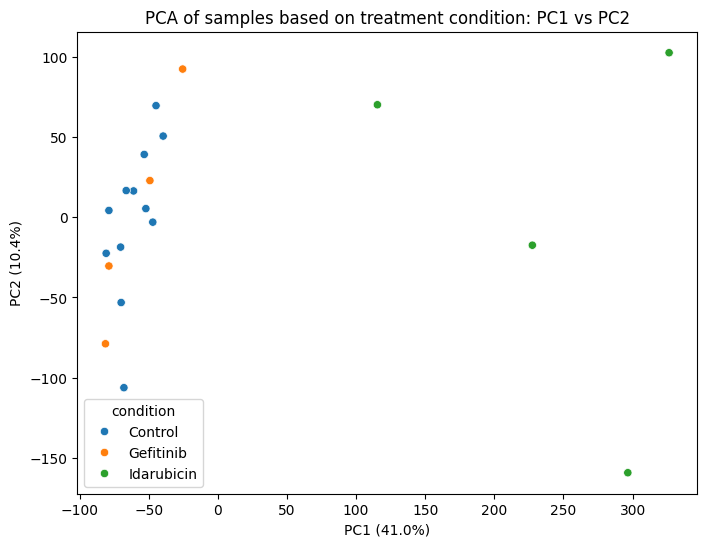

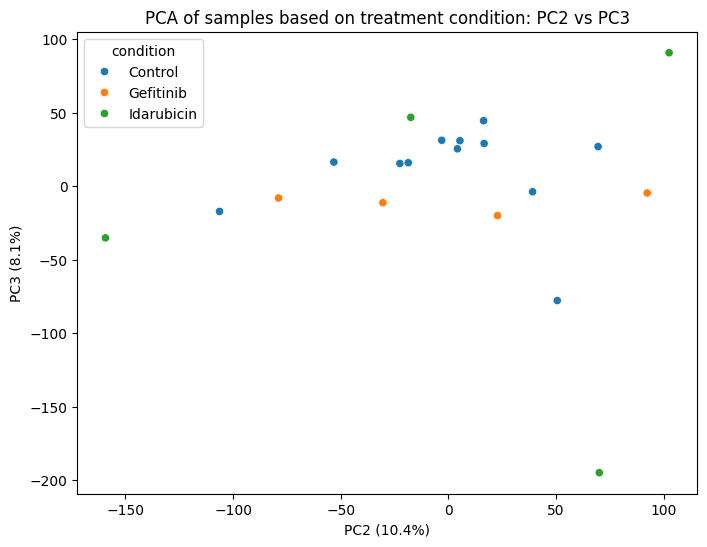

In [33]:
plot_df = pd.DataFrame(
    {
        "PC1": pca_result_matrix[:, 0],
        "PC2": pca_result_matrix[:, 1],
        "PC3": pca_result_matrix[:, 2],
        "condition": metadata_df["treatment"].values,
    }
)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="condition")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC1 vs PC2")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC2", y="PC3", hue="condition")
plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC2 vs PC3")
plt.show()

# DEseq2

## Idarubicin vs Control

In [34]:
drug = "Idarubicin"

metadata_df_filtered_ida = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_ida = counts[metadata_df_filtered_ida.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_ida.T,
    metadata=metadata_df_filtered_ida,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_ida = DeseqStats(deseq_object, contrast=("treatment", "Idarubicin", "Control"))
stat_res_ida.summary()
results_df_ida = stat_res_ida.results_df


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.62 seconds.

Fitting dispersion trend curve...
... done in 2.36 seconds.

Fitting MAP dispersions...
... done in 2.16 seconds.

Fitting LFCs...
... done in 1.91 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 183 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Idarubicin vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           65.207421       -0.231791  0.250358 -0.925839  0.354530   
MIR6859-1         6.825359        0.081561  0.545918  0.149402  0.881237   
MIR1302-2HG       0.078612       -0.173395  3.837651 -0.045183  0.963962   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           58440.996084        0.122716  0.440824  0.278379  0.780722   
TRNE              0.400252       -1.378005  2.810167 -0.490364  0.623876   
CYTB         168485.103532        0.040086  0.429293  0.093378  0.925603   
TRNT              0.150909        0.790971  3.704852  0.213496  0.830940   
TRNP           1096.513513        0.196396  0.355809  0.551971  0.580968   

                 

... done in 1.77 seconds.



In [35]:
# Get upregulated and downregulated genes
upregulated_genes_ida = results_df_ida[
    (results_df_ida["log2FoldChange"] > 2) & (results_df_ida["padj"] < 0.05)
]
downregulated_genes_ida = results_df_ida[
    (results_df_ida["log2FoldChange"] < -2) & (results_df_ida["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_ida.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_ida.shape[0]}")

    Upregulated genes: 6183
    Downregulated genes: 336


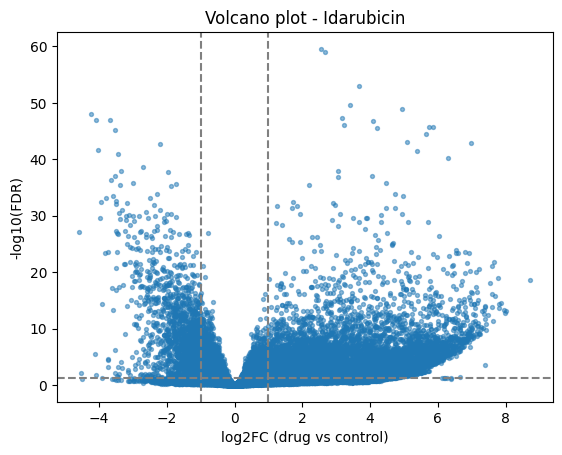

In [36]:
plt.scatter(
    results_df_ida.log2FoldChange, -np.log10(results_df_ida.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

## Gefinitib vs Control

In [37]:
drug = "Gefitinib"

metadata_df_filtered_gef = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_gef = counts[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 2.76 seconds.

Fitting dispersion trend curve...
... done in 2.18 seconds.

Fitting MAP dispersions...
... done in 1.85 seconds.

Fitting LFCs...
... done in 1.74 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 184 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           67.989688        0.209950  0.243883  0.860863  0.389314   
MIR6859-1         6.570236        0.087165  0.555795  0.156829  0.875380   
MIR1302-2HG       0.205009        0.774081  3.684159  0.210111  0.833581   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           61270.934214        0.531070  0.514661  1.031884  0.302126   
TRNE              0.576040        0.264362  1.865684  0.141697  0.887319   
CYTB         173670.016579        0.382910  0.426741  0.897290  0.369564   
TRNT              0.066380        0.295672  3.849808  0.076802  0.938781   
TRNP           1076.775011        0.281788  0.349337  0.806636  0.419876   

                 p

... done in 1.34 seconds.



In [38]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")

    Upregulated genes: 0
    Downregulated genes: 11


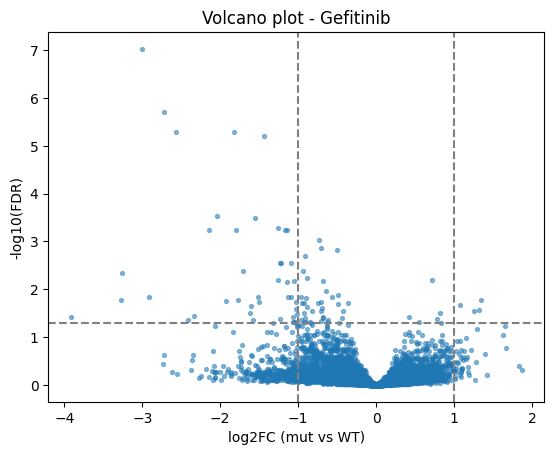

In [39]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (mut vs WT)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

# GSEAPY

In [40]:
GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]

## Idarubicin vs Control

In [41]:
go_upr_results_ida = {}
go_dwr_results_ida = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_ida.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_ida[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_ida.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_ida[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


### Plot upregulated GO terms

In [42]:
for k, v in go_upr_results_ida.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

GO_Biological_Process_2025: (3626, 10)
Error occurred while plotting GO_Biological_Process_2025: Warning: No enrich terms when cutoff = 0.05
GO_Cellular_Component_2025: (303, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (749, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


In [43]:
display(go_upr_results_ida["GO_Biological_Process_2025"].head(5))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Regulation of Dopamine Secretion (GO:0014059),7/11,0.025534,0.999997,0,0,3.913982,14.355548,CHRNB2;GDNF;SYT12;CHRNA6;KCNA2;FGF20;DRD3
1,GO_Biological_Process_2025,Regulation of Natural Killer Cell Activation (...,9/16,0.031110,0.999997,0,0,2.875885,9.979983,ZNF683;KLRC2;KLRC3;LEP;IL12B;PTPN22;IL12A;PRDM...
2,GO_Biological_Process_2025,Cellular Defense Response (GO:0006968),21/47,0.032342,0.999997,0,0,1.807674,6.202850,ITK;CXCL9;KLRC2;NCF2;KLRC3;TRAT1;CD5L;LY96;DCD...
3,GO_Biological_Process_2025,Negative Regulation of T Cell Mediated Cytotox...,5/7,0.032770,0.999997,0,0,5.590401,19.109355,PTPRC;NCKAP1L;KLRC1;FCGR2B;HLA-G
4,GO_Biological_Process_2025,Response to Ethanol (GO:0045471),9/17,0.048317,0.999997,0,0,2.516217,7.624056,CHRNB2;GLRA1;GLRA2;GRIN2A;TH;OPRM1;ADH7;GRIN2B...


### Plot downregulated GO terms

GO_Biological_Process_2025: (1461, 10)
GO_Cellular_Component_2025: (149, 10)
GO_Molecular_Function_2025: (284, 10)


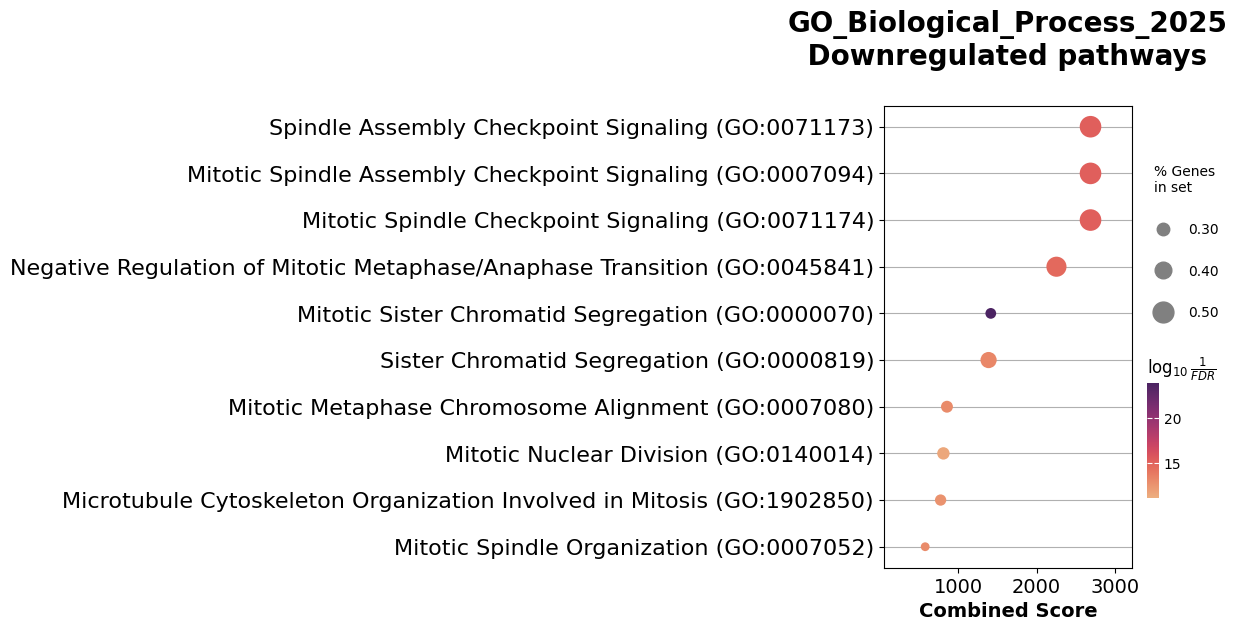

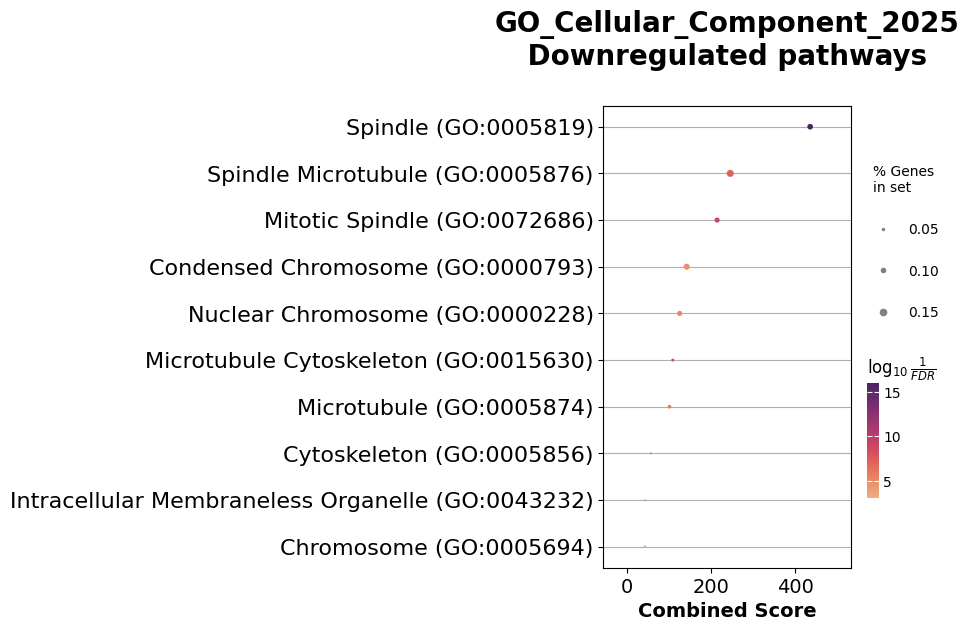

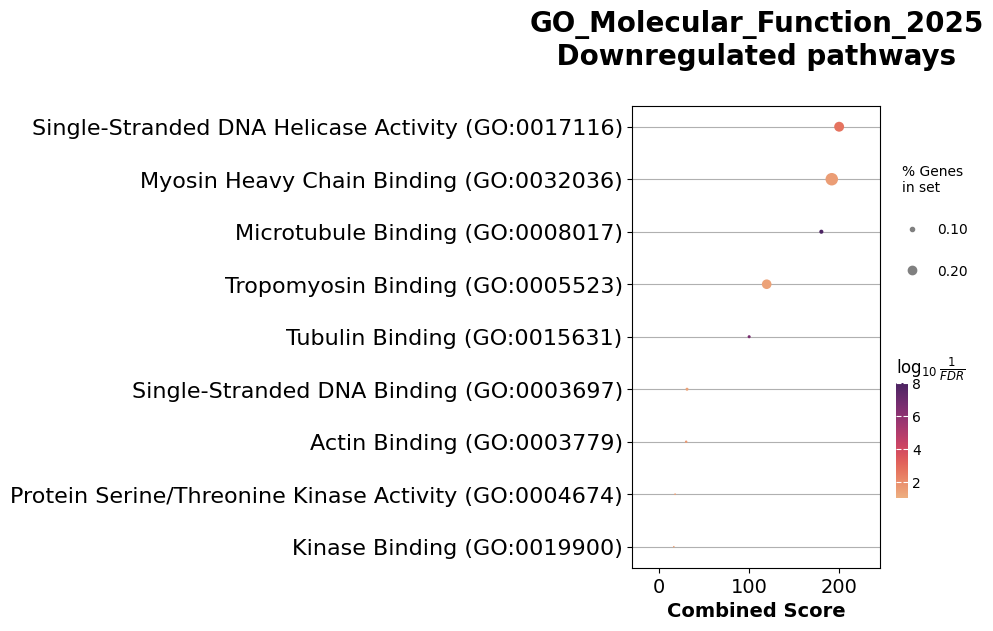

In [44]:
for k, v in go_dwr_results_ida.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

In [45]:
# Check out all results for downregulated GO terms (biological process)
go_dwr_results_ida["GO_Biological_Process_2025"][
    go_dwr_results_ida["GO_Biological_Process_2025"]["Adjusted P-value"] < 0.05
]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Mitotic Sister Chromatid Segregation (GO:0000070),31/120,3.086030e-28,4.508690e-25,0,0,22.354946,1416.085144,UHRF1;CDCA5;NCAPG2;KIF14;CDCA8;NCAPG;KIF11;SKA...
1,GO_Biological_Process_2025,Spindle Assembly Checkpoint Signaling (GO:0071...,14/27,1.792641e-18,6.547623e-16,0,0,65.722408,2685.604344,PLK1;BUB1B;TTK;NDC80;ZWINT;CDC20;CENPF;NUF2;BI...
2,GO_Biological_Process_2025,Mitotic Spindle Assembly Checkpoint Signaling ...,14/27,1.792641e-18,6.547623e-16,0,0,65.722408,2685.604344,PLK1;BUB1B;TTK;NDC80;ZWINT;CDC20;CENPF;NUF2;BI...
3,GO_Biological_Process_2025,Mitotic Spindle Checkpoint Signaling (GO:0071174),14/27,1.792641e-18,6.547623e-16,0,0,65.722408,2685.604344,PLK1;BUB1B;TTK;NDC80;ZWINT;CDC20;CENPF;NUF2;BI...
4,GO_Biological_Process_2025,Negative Regulation of Mitotic Metaphase/Anaph...,14/29,6.725052e-18,1.965060e-15,0,0,56.953623,2251.985672,PLK1;BUB1B;TTK;NDC80;ZWINT;CDC20;CENPF;NUF2;BI...
...,...,...,...,...,...,...,...,...,...,...
151,GO_Biological_Process_2025,Positive Regulation of G2/M Transition of Mito...,3/20,4.333346e-03,4.137921e-02,0,0,10.411765,56.654735,CCNB1;CDK1;DTL
152,GO_Biological_Process_2025,Regulation of Cardiac Conduction (GO:1903779),3/20,4.333346e-03,4.137921e-02,0,0,10.411765,56.654735,RYR2;SLC8A1;CORIN
153,GO_Biological_Process_2025,G1/S Transition of Mitotic Cell Cycle (GO:0000...,5/64,4.405562e-03,4.179563e-02,0,0,5.019458,27.229996,CCNA2;CCNB2;CCNB1;CDK1;CDKN3
154,GO_Biological_Process_2025,Cell Cycle G1/S Phase Transition (GO:0044843),5/66,5.025702e-03,4.737129e-02,0,0,4.854391,25.695212,CCNA2;CCNB2;CCNB1;CDK1;CDKN3


## Gefitinib vs Control

In [46]:
go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [47]:
print(go_upr_results_gef)
print(go_dwr_results_gef)

{}
{}


In [48]:
# --> no enriched pathways found

### Plot upregulated GO terms

In [49]:
for k, v in go_upr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

### Plot downregulated GO terms

In [50]:
for k, v in go_dwr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")